# CodeTMS data visualizations

In [1]:
import pandas as pd
import numpy as np
import os
import random
from matplotlib import pyplot as plt

## Settings (you can change these)

In [2]:
input_version = 2  # corresponds to the output version of the data management script
output_version = 1 # increment this (only relevant if save_plots == True)
save_plots = True  # whether to save the visualizations

In [3]:
color_scheme = "basic" # options: basic, pastel, grayscale, neon

In [4]:
# make the output directory
if save_plots:
    path = os.path.realpath("__file__")[:-len("__file__")]
    output_path = os.path.join(path, "visualizations-{}".format(output_version))
    try:
        os.mkdir(output_path)
    except OSError as error:
        print(error)

[Errno 17] File exists: '/home/emshedde/research/tms/final-artifacts/visualizations-1'


## Read in the data

In [5]:
df = pd.read_csv("processed-data-{}/tms-functional-data-v{}.csv".format(input_version, input_version), converters={"id" : str})

df.rename(columns={"adjusted_stimulus" : "stimulus"}, inplace=True)

display(df.head())

,id,condition,question,actual_response,correct,correct_response,domain,response_time,session_num,original_stimulus,test_version,mr_difficulty,programming_difficulty,has_survey,is_mr,is_programming,stimulus
0,00071,m1,0,a,True,a,list/array,11.120933,0,4,3,2,3,True,False,True,4
1,00071,m1,1,b,True,b,code,13.503331,0,127,3,2,3,True,False,True,152
2,00071,m1,2,b,True,b,code,9.705927,0,140,3,2,3,True,False,True,165
3,00071,m1,3,a,True,a,code,6.805621,0,126,3,2,3,True,False,True,151
4,00071,m1,4,b,True,b,tree,11.838852,0,59,3,2,3,True,False,True,60


In [6]:
df["domain"].value_counts() # there is some imbalance here, as mentioned in section 4.2.1 of the paper

tree               801
code               572
list/array         531
PSVT:R II          461
shepard-metzler    397
Name: domain, dtype: int64

In [7]:
# make a dataframe where the "individuals" are the question prompts rather than the people
# each row is a question prompt ("stimulus"), and stores its category (domain), rate at
# which people got it correct (across all TMS treatment conditions), number of times it was
# seen, and average response time (across all TMS treatment conditions)
stimuli = df.groupby("stimulus").agg({"domain" : "first", 
                                      "correct" : [np.mean, len], 
                                      "response_time" : np.mean, 
                                      "test_version" : "first"}).reset_index()
stimuli.columns = ["stimulus", "domain", "correct_rate", "count", "avg_time", "test_version"]
stimuli

,stimulus,domain,correct_rate,count,avg_time,test_version
0,1,list/array,0.937500,16,18.677714,3
1,2,list/array,0.933333,15,16.573690,2
2,3,list/array,1.000000,16,22.778801,3
3,4,list/array,0.937500,16,13.694127,3
4,5,list/array,0.933333,15,10.930348,2
...,...,...,...,...,...,...
178,179,code,0.500000,14,60.404930,2
179,180,code,1.000000,14,28.964374,1
180,181,code,0.785714,14,48.795377,3
181,182,code,1.000000,14,44.461008,2


In [8]:
stimuli["count"].value_counts() # for most stimuli, we have data from 15 participants

15    100
16     50
14     33
Name: count, dtype: int64

So 33 stimuli have been observed 14 times, 100 stimuli have been observed 15 times, and 50 stimuli have been observed 16 times.

In [9]:
df.groupby("test_version")["id"].nunique()

test_version
1    15
2    15
3    16
Name: id, dtype: int64

The above cell gives the number of times that each test version was used.

## Visualization

Initial setup to establish the color scheme.

In [10]:
anon_domains = "A" in df["domain"].unique()
anon_conditions = "A" in df["condition"].unique()

In [11]:
def set_domain_color(anon, scheme):
    color_options = {
        "basic" : ["red", "orange", "SeaGreen", "CornflowerBlue", "DarkMagenta"],
        "pastel" : ["#ffb3ba", "#ffdfba", "#ffffba", "#baffc9", "#bae1ff"],
        "grayscale" : ["0.8", "0.6", "0.4", "0.2", "0.0"],
        "neon" : ["DeepPink", "Gold", "Lime", "cyan", "BlueViolet"]
    }
    
    label_options = {
        True : ["A", "B", "C", "D", "E"],
        False : ["list/array", "tree", "shepard-metzler", "PSVT:R II", "code"]
    }
    
    return {label_options[anon][i] : color_options[scheme][i] for i in range(5)}

colors = set_domain_color(anon_domains, color_scheme)

### Figure 1: Per-question average correctness, by domain

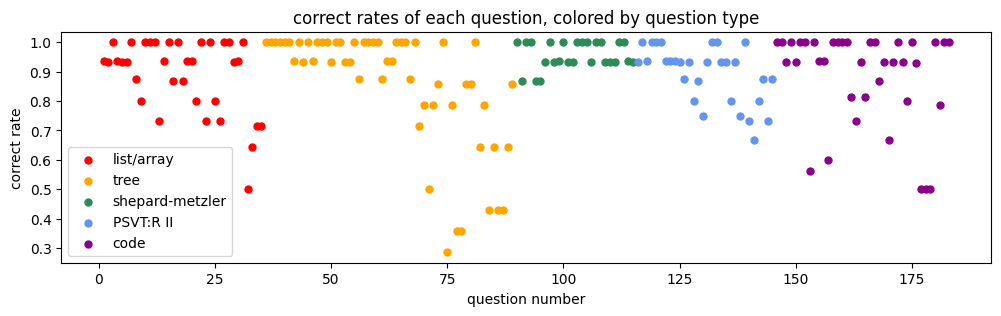

In [12]:
plt.figure(figsize=(12, 3))
for cat, color in colors.items():
    xs = stimuli[stimuli["domain"] == cat]["stimulus"]
    ys = stimuli[stimuli["domain"] == cat]["correct_rate"]
    plt.scatter(xs, ys, s=25, c=color, label=cat)

plt.xlabel("question number")
plt.ylabel("correct rate")
plt.title("correct rates of each question, colored by question type")
plt.legend()

if save_plots:
    plt.savefig(os.path.join(output_path, "corr-rate_question-num_domain.png"), bbox_inches="tight")

plt.show()

### Figure 2: Per-question average response time, by domain

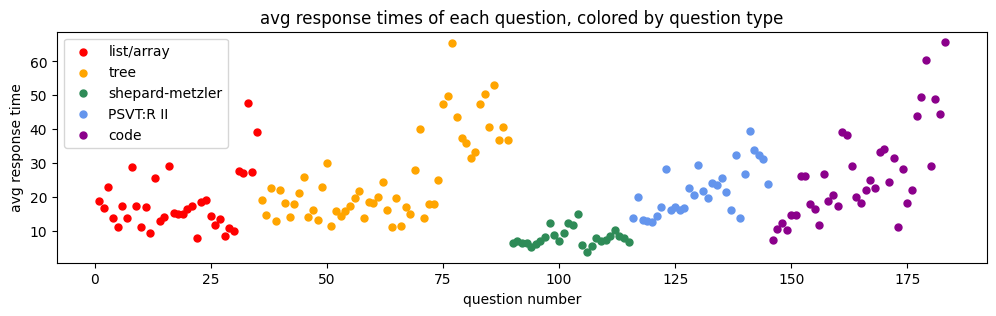

In [13]:
plt.figure(figsize=(12, 3))
for cat, color in colors.items():
    xs = stimuli[stimuli["domain"] == cat]["stimulus"]
    ys = stimuli[stimuli["domain"] == cat]["avg_time"]
    plt.scatter(xs, ys, s=25, c=color, label=cat)

plt.xlabel("question number")
plt.ylabel("avg response time")
plt.title("avg response times of each question, colored by question type")
plt.legend()

if save_plots:
    plt.savefig(os.path.join(output_path, "resp-time_question-num_domain.png"), bbox_inches="tight")
    
plt.show()

### Figure 3: Per-question average correctness vs average response time, by domain

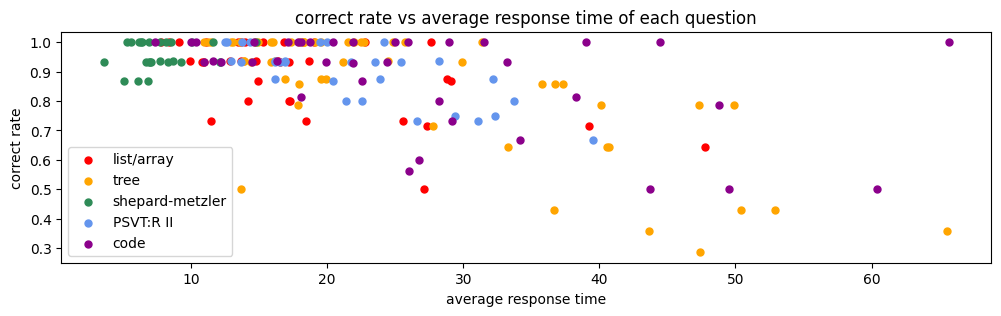

In [14]:
plt.figure(figsize=(12, 3))
for cat, color in colors.items():
    xs = stimuli[stimuli["domain"] == cat]["avg_time"]
    ys = stimuli[stimuli["domain"] == cat]["correct_rate"]
    plt.scatter(xs, ys, s=25, c=color, alpha=1, label=cat)

plt.xlabel("average response time")
plt.ylabel("correct rate")
plt.title("correct rate vs average response time of each question")
plt.legend()

if save_plots:
    plt.savefig(os.path.join(output_path, "corr-rate_resp-time_domain.png"), bbox_inches="tight")
    
plt.show()

### Figure 4: Per-question average correctness, by treatment condition

In [15]:
def set_condition_color(anon, scheme):
    color_options = {
        "basic" : ["red", "green", "blue"],
        "pastel" : ["#ffb3ba", "#ffffba", "#baffc9"],
        "grayscale" : ["0.6", "0.3", "0.0"],
        "neon" : ["DeepPink", "Lime", "BlueViolet"]
    }
    
    label_options = {
        True : ["X", "Y", "Z"],
        False : ["m1", "sma", "vertex"]
    }
    
    return {label_options[anon][i] : color_options[scheme][i] for i in range(3)}

colors = set_condition_color(anon_conditions, color_scheme)

In [16]:
bounds = stimuli.groupby("domain").first()["stimulus"].tolist() + [max(stimuli["stimulus"])]
bounds.sort()
bounds[0] = 0

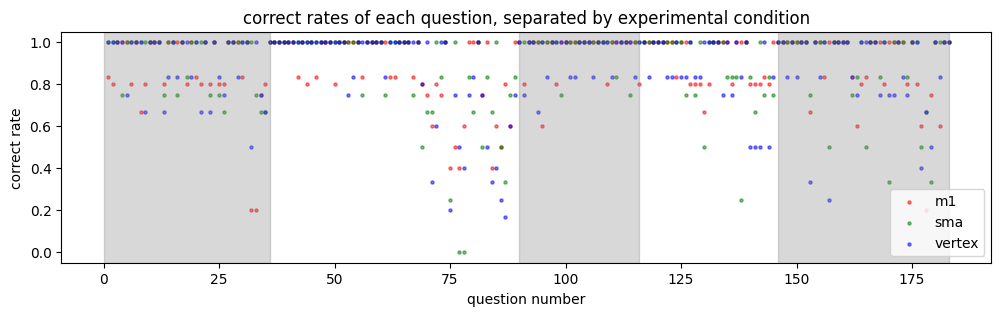

In [17]:
# start off the plot
plt.figure(figsize=(12, 3))

# plot all the points for each experimental condition
for condition, color in colors.items():
    stratified_stimuli = df[df["condition"] == condition].groupby("stimulus").agg({"domain" : "first", "correct" : [np.mean, len], "response_time" : np.mean}).reset_index()
    stratified_stimuli.columns = ["stimulus", "domain", "correct_rate", "count", "avg_time"]
    
    
    xs = stratified_stimuli["stimulus"]
    ys = stratified_stimuli["correct_rate"]
    plt.scatter(xs, ys, s=5, c=color, alpha=0.5, label=condition)

# section off the different categories of questions
for k in range(0, len(bounds), 2):
    plt.axvspan(bounds[k], bounds[k+1], alpha=0.3, color="0.5")

# score up the empty block of indices
#plt.axvspan(151, 200, alpha=0.5, facecolor="1.0", edgecolor="0.0", hatch="x")

# set the labels
plt.xlabel("question number")
plt.ylabel("correct rate")
plt.title("correct rates of each question, separated by experimental condition")
plt.legend(loc=4)

if save_plots:
    plt.savefig(os.path.join(output_path, "corr-rate_question-num_ condition.png"), bbox_inches="tight")
    
plt.show()

The stimulus categories go (if anonymized):
<p style="text-align: right;">
    <i> A </i> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;&emsp; 
    <i> B </i> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; 
    <i> C </i> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &ensp;
    <i> D </i> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;
    <i> E </i> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;
</p>

### Figure 5: Per-question average response time, by treatment condition

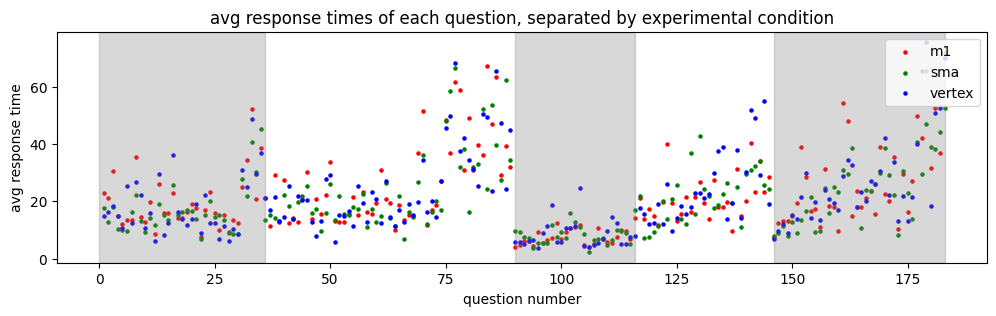

In [18]:
# start off the plot
plt.figure(figsize=(12, 3))

# plot all the points for each experimental condition
for condition, color in colors.items():
    stratified_stimuli = df[df["condition"] == condition].groupby("stimulus").agg({"domain" : "first", "correct" : [np.mean, len], "response_time" : np.mean}).reset_index()
    stratified_stimuli.columns = ["stimulus", "domain", "correct_rate", "count", "avg_time"]
    
    xs = stratified_stimuli["stimulus"]
    ys = stratified_stimuli["avg_time"]
    plt.scatter(xs, ys, s=5, c=color, label=condition)

# section off the different categories of questions
for k in range(0, len(bounds), 2):
    plt.axvspan(bounds[k], bounds[k+1], alpha=0.3, color="0.5")

# score up the empty block of indices
#plt.axvspan(151, 200, alpha=0.5, facecolor="1.0", edgecolor="0.0", hatch="x")

# set the labels
plt.xlabel("question number")
plt.ylabel("avg response time")
plt.title("avg response times of each question, separated by experimental condition")
plt.legend(loc=1)

if save_plots:
    plt.savefig(os.path.join(output_path, "resp-time_question-num_condition.png"), bbox_inches="tight")

plt.show()

Same as above, the stimulus categories go:
<p style="text-align: right;">
    <i> A </i> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;&emsp; 
    <i> B </i> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; 
    <i> C </i> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &ensp;
    <i> D </i> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;
    <i> E </i> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;
</p>

### Figure 6: Per-question average correctness vs average response time, by treatment condition

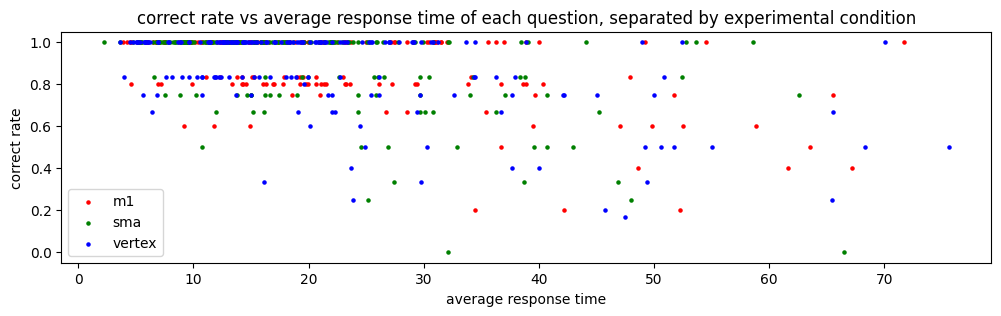

In [19]:
plt.figure(figsize=(12, 3))
for condition, color in colors.items():
    stratified_stimuli = df[df["condition"] == condition].groupby("stimulus").agg({"domain" : "first", "correct" : [np.mean, len], "response_time" : np.mean}).reset_index()
    stratified_stimuli.columns = ["stimulus", "domain", "correct_rate", "count", "avg_time"]
    
    xs = stratified_stimuli["avg_time"]
    ys = stratified_stimuli["correct_rate"]
    plt.scatter(xs, ys, s=5, c=color, label=condition)

plt.xlabel("average response time")
plt.ylabel("correct rate")
plt.title("correct rate vs average response time of each question, separated by experimental condition")
plt.legend()

if save_plots:
    plt.savefig(os.path.join(output_path, "corr-rate_resp-time_condition.png"), bbox_inches="tight")

plt.show()

As expected, this graph looks pretty gross because all the points are plotted on top of each other.

## Examine outlier stimuli
From Figure 1, we can see a few questions with very poor performance, leading us to wonder if they might have been coded incorrectly. Here, we pull the indices for those questions so we can double check. The questions that will show up here have indeed been coded correctly, so this section of code isn't particularly useful to readers; however, early in our data analysis we found 4 mis-coded questions (\#106, \#118, \#140, and \#332) via this mechanism.

In [20]:
thresh = 0.5 # from looking at the models

In [21]:
stimuli[stimuli["correct_rate"] < thresh]

,stimulus,domain,correct_rate,count,avg_time,test_version
74,75,tree,0.285714,14,47.401885,1
76,77,tree,0.357143,14,65.545791,3
77,78,tree,0.357143,14,43.650319,1
83,84,tree,0.428571,14,50.388668,3
85,86,tree,0.428571,14,52.933511,2
86,87,tree,0.428571,14,36.677345,3


In [22]:
for stimulus in stimuli[stimuli["correct_rate"] < thresh]["stimulus"].tolist():
    correct_response = df[df["stimulus"] == stimulus]["correct_response"].iloc[0]
    original_index = df[df["stimulus"] == stimulus]["original_stimulus"].iloc[0]
    print("Stimulus #{} (originally #{}): answer choice {}".format(stimulus, original_index, correct_response))

Stimulus #75 (originally #307): answer choice a
Stimulus #77 (originally #309): answer choice b
Stimulus #78 (originally #310): answer choice a
Stimulus #84 (originally #318): answer choice b
Stimulus #86 (originally #320): answer choice a
Stimulus #87 (originally #321): answer choice a


### Figures 7-9: Summary statistics and distribution of response variables

Here we show the (lack of) symmetry in the response variables, which relates to our choice to log-transform them in the analysis. The R script containing the linear regression code includes additional visualization and quantification of the symmetry of Pearson residuals for the fitted models.

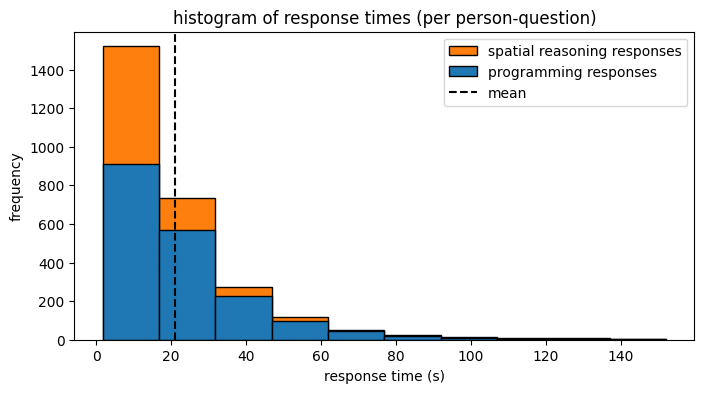

In [23]:
# Figure 7
plt.figure(figsize=(8, 4))

c0 = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
c1 = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

_, bins, _ = plt.hist(df["response_time"], edgecolor="black", color=c1, label="spatial reasoning responses")
plt.hist(df[df["is_programming"] == True]["response_time"], bins=bins, edgecolor="black", color=c0, label="programming responses")

plt.axvline(x=np.mean(df["response_time"]), color="black", linestyle="dashed", label="mean")

plt.xlabel("response time (s)")
plt.ylabel("frequency")
plt.title("histogram of response times (per person-question)")
plt.legend()

if save_plots:
    plt.savefig(os.path.join(output_path, "resp-times_hist.png"), bbox_inches="tight")

plt.show()

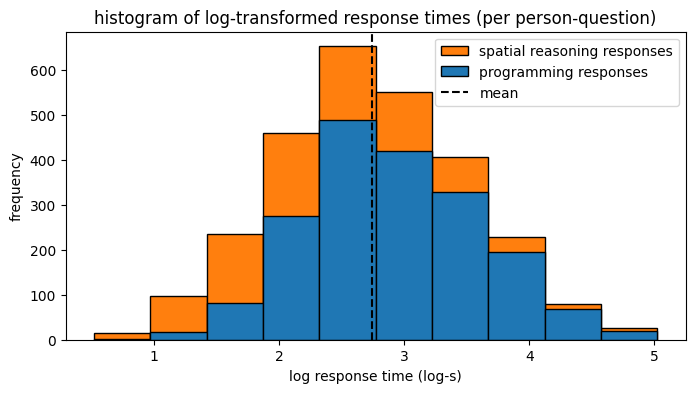

In [24]:
# Figure 8
plt.figure(figsize=(8, 4))

_, bins, _ = plt.hist(np.log(df["response_time"]), edgecolor="black", color=c1, label="spatial reasoning responses")
plt.hist(np.log(df[df["is_programming"] == True]["response_time"]), bins=bins, edgecolor="black", color=c0, label="programming responses")

plt.axvline(x=np.mean(np.log(df["response_time"])), color="black", linestyle="dashed", label="mean")

plt.xlabel("log response time (log-s)")
plt.ylabel("frequency")
plt.title("histogram of log-transformed response times (per person-question)")
plt.legend()

if save_plots:
    plt.savefig(os.path.join(output_path, "log-resp-time_hist.png"), bbox_inches="tight")

plt.show()

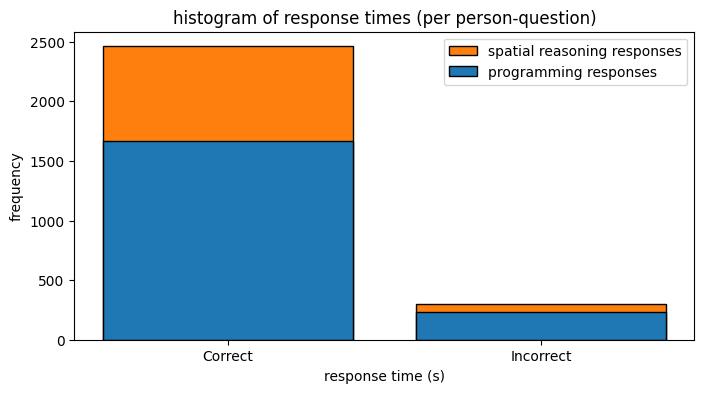

In [25]:
# Figure 9
plt.figure(figsize=(8, 4))

counts = df["correct"].value_counts()
assert(list(counts.index) == list([True, False]))
counts.index = ["Correct", "Incorrect"]
plt.bar(counts.index, counts.values, edgecolor="black", color=c1, label="spatial reasoning responses")

counts = df[df["is_programming"] == True]["correct"].value_counts()
assert(list(counts.index) == list([True, False]))
counts.index = ["Correct", "Incorrect"]
plt.bar(counts.index, counts.values, edgecolor="black", color=c0, label="programming responses")

plt.xlabel("response time (s)")
plt.ylabel("frequency")
plt.title("histogram of response times (per person-question)")
plt.legend()

if save_plots:
    plt.savefig(os.path.join(output_path, "corr-rate_hist.png"), bbox_inches="tight")

plt.show()